# <center>Stochastic Optimization and Automatic Differentiation for Machine Learning

>Etude autour de l'article : Stochastic Dual Coordinate Ascent Methods for Regularized Loss Minimization (Shai Shalev-Shwartz,Tong Zhang) (source : http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf )

Vincent LE MEUR

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn import preprocessing
from numpy.random import permutation
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## I) Introduction

L'objectif de ce notebook est de résoudre un problème de Support Vector Machines (SVM) dans le cadre d'une classification binaire.

Nous allons utiliser les notations suivantes :
- $X_1,..,X_n \in \mathbb{R}^d$ pour les variables explicatives
- $y_1,..,y_n \in \{-1,1\}$  pour les labels associés
- $ \lambda $ le paramètre de régularisation propre au SDCA
- $ w \in \mathbb{R} $ le paramètre à optimiser du problème primal
- $ \phi_i(a)=max(0,1-y_ia) $ la fonction de perte (Hinge loss) associée au SVM étudié



Le problème primal associé à l'optimisation de notre SVM consiste alors avec les notations précédentes à minimiser l'application pénalisée suivante : $P(\omega)= \dfrac{1}{n} \sum_{i=1}^{n}\phi_i(\omega^{T}X_i) + \dfrac{\lambda}{2}||\omega||^2$ (1)

Une approche alternative (Dual Coordinate Ascent) à ce problème est celle qui étudie le problème dual. En prenant le conjugué convexe de notre fonction de perte $\phi$ précédente définie par $\phi_i^*(u)=max_z(zu-\phi_i(z))$, nous pouvons en effet définir le probème équivalent au précédent qui est de maximiser : $D(\alpha) = \dfrac{1}{n} \sum_{i=1}^{n}-\phi_i^*(-\alpha_i)-\dfrac{\lambda}{2}||\dfrac{1}{\lambda n}\sum_{i=1}^{n}\alpha_i x_i||^2$ où ici $\alpha \in \mathbb{R}^n$ (2)

Nous voyons un lien clair entre les deux problèmes. En effet, soit l'application $\omega(\alpha) = \dfrac{1}{\lambda n}\sum_{i=1}^{n}\alpha_i x_i$ et $\alpha^*$ la solution du problème dual (2) alors $\omega^*=\omega(\alpha^*)$ est également la solution optimale du problème primal (1)

On définit ci-dessous deux fonctions "func_primal" et "func_dual" qui vont représenter les problèmes (1) et (2) précédents : 

In [3]:
def func_primal(omega,Lambda,n,X,y):
    return(1/n * np.sum(np.fmax(np.zeros(n), np.ones(n) - y * X.dot(omega))) + Lambda/2 * np.linalg.norm(omega))

def func_dual(alpha,Lambda,n,X,y):
    return(-(1/n * np.sum(-y * alpha) + Lambda/2 * np.linalg.norm(1/(Lambda * n) * X.T.dot(alpha))))

Nous allons alors étudier une approche utilisant cette dualité (SDCA) et la comparer à une approche de descente de sous Gradient :
- Stochastic Dual Coordinate Ascent (SDCA) 
- Primal Estimated subGrAdient SOlver for SVM (PEGASOS)

## II) Mise en place du SDCA

L'algorithme SDCA consiste donc à résoudre de manière ittérative les deux problèmes de la manière suivante :

![title](SDCA_generique.png)

L'algorithme comporte deux types de sorties :
- Une sortie moyennée qui correspond à prendre pour $\omega$ final une moyenne des dernières itérations (ce nombre d'itérations considérées est fixé par le paramètre $T_0$)
- Une sortie "aléatoire" ou l'on sélectionne $\omega$ final aléatoirement parmis les dernières itérations (toujours fixées par le paramètre $T_0$)

On cherche à chaque étape à calculer $\Delta \alpha_i$. Il se trouve que pour le problème précis que l'on se fixe (résoudre un SVM avec perte Hinge) , on connaît explicitement cette quantité qui est : $ \Delta \alpha_i = max(-1,  min( \dfrac{y_i -x_i^T\omega^{t-1}}{||x_i||^2/(\lambda n)} + \alpha_i^{t-1}) ) -\alpha_i^{t-1}$

Nous allons mettre en place deux variantes de cet algorithme : SDCA et SCDCA_perm. La différence entre ces deux algorithmes est la manière d'ittérer. Pour SDCA à chaque ittération, on pioche uniformément avec remise un $i \in \{1,..,n\}$ alors que pour SDCA_perm on effectue à l'avance une permutation aléatoire de  $\{1,..n\}$ sur laquelle on travaille.

In [4]:
def SDCA(nb_epoch,T0,X,y,Lambda,method):
    n=X.shape[0]
    list_alpha=[]
    list_omega=[]
    list_primal=[]
    list_dual=[]
    alpha=np.zeros(n)
    T=nb_epoch*n
    omega = (1/(Lambda*n)) * (X.T.dot(alpha))
    for t in range(1,T):
        # On choisit un i aléatoirement et uniformément (avec remise)
        i=int(np.random.uniform(0,n))
        # On calcule explicitement le delta_alpha_i 
        delta_alpha=y[i]*max(0,min(1, (1-np.dot(X[i].T,np.dot(omega,y[i])))/(np.linalg.norm(X[i])/(Lambda*n)) +alpha[i]*y[i])) -alpha[i]
        alpha[i]=alpha[i]+delta_alpha
        list_alpha.append(alpha)
        omega=omega +(1/(Lambda*n))*delta_alpha*X[i]
        list_omega.append(omega)
        list_primal.append(func_primal(omega,Lambda,n,X,y))
        list_dual.append(func_dual(alpha,Lambda,n,X,y))
    if method=="random":
        k=int(np.random.uniform(T0,T))
        omega_final=list_omega[k]
        alpha_final=list_alpha[k]
    if method=="average":
        omega_final=(1/(T-T0))*sum(list_omega[k] for k in range(T0,T-1))
        alpha_final=(1/(T-T0))*sum(list_alpha[k] for k in range(T0,T-1))
    return(omega_final,list_primal,list_dual,list_alpha)

In [5]:
def SDCA_perm(nb_epoch,T0,X,y,Lambda,method):
    n=X.shape[0]
    list_alpha=[]
    list_omega=[]
    list_primal=[]
    list_dual=[]
    alpha=np.zeros(n)
    T=nb_epoch*n
    omega = (1/(Lambda*n)) * (X.T.dot(alpha))
    for k in range(1,nb_epoch+1):
        # On fixe une permutation sur {1,..,n}
        perm=permutation(n)
        for i in range(len(perm)):
            # On calcule explicitement le delta_alpha_i 
            delta_alpha=y[i]*max(0,min(1, (1-np.dot(X[i].T,np.dot(omega,y[i])))/(np.linalg.norm(X[i])/(Lambda*n)) +alpha[i]*y[i])) -alpha[i]
            alpha[i]=alpha[i]+delta_alpha
            list_alpha.append(alpha)
            omega=omega +(1/(Lambda*n))*delta_alpha*X[i]
            list_omega.append(omega)
            list_primal.append(func_primal(omega,Lambda,n,X,y))
            list_dual.append(func_dual(alpha,Lambda,n,X,y))
    if method=="random":
        k=int(np.random.uniform(T0,T))
        omega_final=list_omega[k]
        alpha_final=list_alpha[k]
    if method=="average":
        omega_final=(1/(T-T0))*sum(list_omega[k] for k in range(T0,T-1))
        alpha_final=(1/(T-T0))*sum(list_alpha[k] for k in range(T0,T-1))
    return(omega_final,list_primal,list_dual,list_alpha,list_omega)

## III) Mise en place de PEGASOS

Nous allons ici mettre en place l'algorithme "concurrent" Pegasos qui effectue une descente de gradient stochastique sur notre problème primal (1). Nous donnons ci-dessous son "pseudo code" :

![title](pegasos.png)

Ici encore nous allons donner deux variantes de cet algorithme. Une variante pegasos qui, comme indiqué ci-dessus prends un i à chaque itération uniformément parmi {1,..,n}, et une variante pegasos_perm qui à chaque epoch fixe une permutation aléatoire de {1,..,n} et itére sur celle_ci :

In [6]:
def pegasos(nb_epoch,X,y,Lambda):
    n=X.shape[0]
    d=X.shape[1]
    list_omega=[]
    list_primal=[]
    omega =np.ones(d)
    T=nb_epoch*n
    for t in range(1,T):
        # On choisit un i aléatoirement et uniformément
        i=int(np.random.uniform(0,n))
        eta_t=1/(Lambda*t)
        if np.dot(X[i].T,np.dot(omega,y[i]))<1:
            omega=(1-eta_t*Lambda)*omega + eta_t*y[i]*(X[i])
            list_omega.append(omega)
            list_primal.append(func_primal(omega,Lambda,n,X,y))
        else:
            omega=(1-eta_t*Lambda)*omega
            list_omega.append(omega)
            list_primal.append(func_primal(omega,Lambda,n,X,y))
    return(omega,list_primal) 

In [7]:
def pegasos_perm(nb_epoch,X,y,Lambda):
    n=X.shape[0]
    d=X.shape[1]
    list_omega=[]
    list_primal=[]
    omega =np.ones(d)
    T=nb_epoch*n
    t=1
    for k in range(1,nb_epoch+1):
        # On fixe une permutation sur {1,..n}
        perm=permutation(n)
        for i in range(len(perm)):
            eta_t=1/(Lambda*t)
            if np.dot(X[i].T,np.dot(omega,y[i]))<1:
                omega=(1-eta_t*Lambda)*omega + eta_t*y[i]*(X[i])
                list_omega.append(omega)
                list_primal.append(func_primal(omega,Lambda,n,X,y))
            else:
                omega=(1-eta_t*Lambda)*omega
                list_omega.append(omega)
                list_primal.append(func_primal(omega,Lambda,n,X,y))
            t=t+1
    return(omega,list_primal) 

## IV) Analyse

Nous allons à présent analyser nos algorithmes précédents sur deux datasets distincts. Nous allons regarder l'évolution de la convergence de notre minimisation ainsi que la précision finale obtenue dans le problème de classification.

Le premier correspond à un dataset de détection du cancer du sein disponible sur sklearn :

In [8]:
data = load_breast_cancer()
X=data["data"]
y=data["target"]
#intercept=np.ones(shape=(X.shape[0],1))
#X=np.append(X,intercept,axis=1)
X=preprocessing.normalize(X)
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X, y, test_size=0.3)
X.shape

(569, 30)

Le second est un dataset artificiel effectué à partir de réalisations bruitées d'une loi normale :

In [9]:
n_samples, n_features = 1000, 50
A = np.random.standard_normal((n_samples, n_features))
#intercept=np.ones(shape=(A.shape[0],1))
#A=np.append(A,intercept,axis=1)
w = np.random.randn(n_features)
b = A.dot(w) + np.random.randn(n_samples)
y_sample = np.sign(b)
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(A, y_sample, test_size=0.3)
A.shape

(1000, 50)

Nous créons enfin ci-dessous une fonction accuracy qui va nous permettre d'évaluer la précision finale obtenue par les algorithmes :

In [10]:
def accuracy(w,X,y):
    y_result = np.sign(X.dot(w))
    for k in range(len(y_result)):
        if y_result[k]==-1:
            y_result[k]=0
    Result=[]
    for k in range(len(y_result)):
        Result.append(abs(y_result[k]-y[k]))
    Prec =(1- sum(Result)/(len(y_result)))*100
    return(Prec)    

Nous allons dans un premier temps évaluer pour chacun des algorithmes (SDCA et PEGASOS) la différence la différence de convergence pour les deux variantes (avec ou sans permutation) pour les données du cancer du sein :

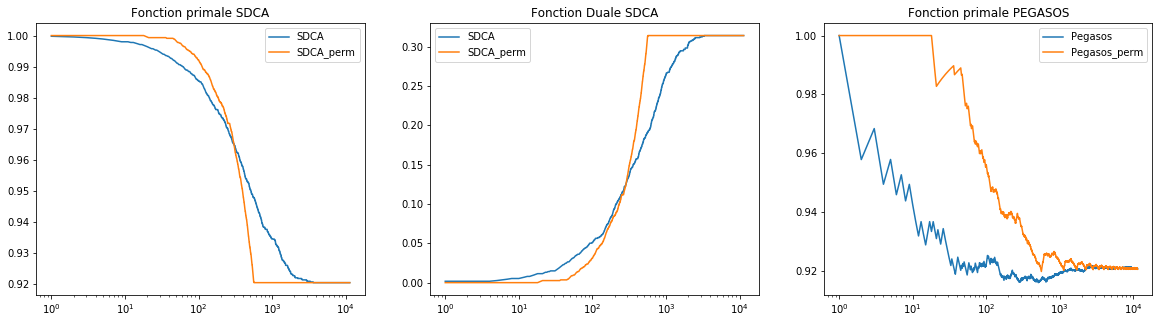

In [11]:
fig = plt.figure(figsize=(20,5))

ax1=plt.subplot(131)
plot(SDCA(20,2000,X,y,1,method="random")[1],label="SDCA")
plot(SDCA_perm(20,2000,X,y,1,method="random")[1],label="SDCA_perm")
plt.title("Fonction primale SDCA")
plt.legend()
ax1.set_xscale("log")
ax2=plt.subplot(133)
plot(pegasos(20,X,y,1)[1],label="Pegasos")
plot(pegasos_perm(20,X,y,1)[1],label="Pegasos_perm")
plt.title("Fonction primale PEGASOS")
ax2.set_xscale("log")
plt.legend()
ax3=plt.subplot(132)
plot(SDCA(20,2000,X,y,1,method="random")[2],label="SDCA")
plot(SDCA_perm(20,2000,X,y,1,method="random")[2],label="SDCA_perm")
plt.title("Fonction Duale SDCA")
ax3.set_xscale("log")
plt.legend()
plt.show()

Nous effectuons la même étude concernant cette fois les données simulées :

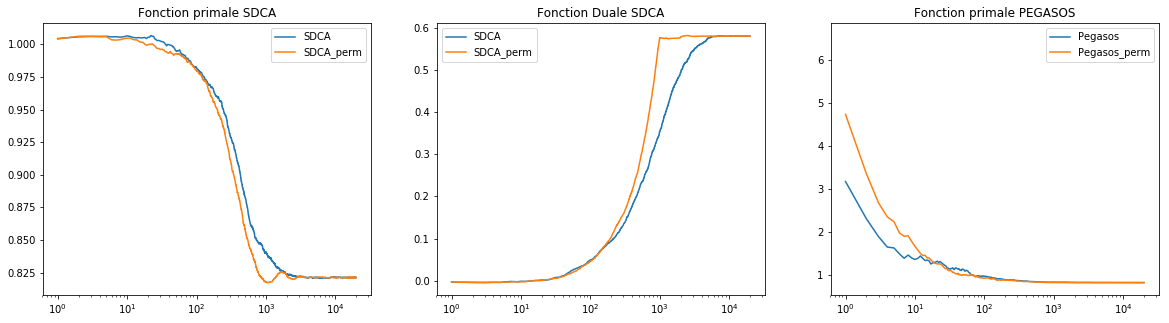

In [12]:
fig = plt.figure(figsize=(20,5))


ax1=plt.subplot(131)
plot(SDCA(20,2000,A,y_sample,1,method="random")[1],label="SDCA")
plot(SDCA_perm(20,2000,A,y_sample,1,method="random")[1],label="SDCA_perm")
plt.title("Fonction primale SDCA")
plt.legend()
ax1.set_xscale("log")
ax2=plt.subplot(133)
plot(pegasos(20,A,y_sample,1)[1],label="Pegasos")
plot(pegasos_perm(20,A,y_sample,1)[1],label="Pegasos_perm")
plt.title("Fonction primale PEGASOS")
ax2.set_xscale("log")
plt.legend()
ax3=plt.subplot(132)
plot(SDCA(20,2000,A,y_sample,1,method="random")[2],label="SDCA")
plot(SDCA_perm(20,2000,A,y_sample,1,method="random")[2],label="SDCA_perm")
plt.title("Fonction Duale SDCA")
plt.legend()
ax3.set_xscale("log")
plt.show()

En terme de convergence la variante "permutation" semble mieux "performer" sur les deux datasets pour l'algorithme SDCA, en revanche l'efficacité de la version "permutation" de PEGASOS a des performances plus discutable sur le premier dataset.
Pour la suite nous garderons alors les algorithmes <b>SDCA_perm</b> et <b>pegasos</b> pour notre étude.

Jusqu'ici,nous avons considéré l'intégralité de nos données pour minimiser la fonction. Nous allons ici utiliser le découpage dataset d'apprentissage/dataset de test pour évaluer la précision des algorithmes également.

Commençons par le premier dataset portant sur le cancer du sein :

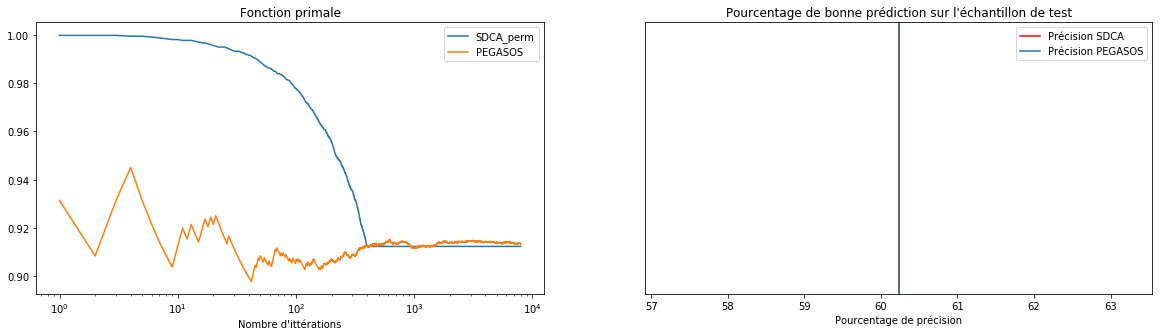

In [13]:
w1_SDCA = SDCA_perm(20,2000,Xtrain1,ytrain1,1,method="random")[0]
primal_list1_SDCA=SDCA_perm(20,2000,Xtrain1,ytrain1,1,method="random")[1]
y_result1_SDCA = np.sign(Xtest1.dot(w1_SDCA))


w1_pegasos = pegasos(20,Xtrain1,ytrain1,1)[0]
primal_list1_pegasos=pegasos(20,Xtrain1,ytrain1,1)[1]
y_result1_pegasos = np.sign(Xtest1.dot(w1_pegasos))

fig = plt.figure(figsize=(20,5))


ax1=plt.subplot(121)
plot(primal_list1_SDCA,label="SDCA_perm")
plot(primal_list1_pegasos,label="PEGASOS")
plt.title("Fonction primale")
plt.legend()
plt.xlabel("Nombre d'ittérations")
ax1.set_xscale("log")
plt.subplot(122)
#Xtest1= np.delete(Xtest1,30,1) 
plt.axvline(accuracy(w1_SDCA,X=Xtest1,y=ytest1),label="Précision SDCA",color="red")
plt.axvline(accuracy(w1_pegasos,X=Xtest1,y=ytest1),label="Précision PEGASOS")
plt.title("Pourcentage de bonne prédiction sur l'échantillon de test")
plt.xlabel("Pourcentage de précision")
plt.yticks([])
plt.legend()

plt.show()

Nos deux algorithmes tendent quasiment vers le même $\omega$ ce qui implique un taux de précision similaire (environ 60%) qui est plutôt faible. En terme de convergence, il semble que l'algorithme PEGASOS décroit plus rapidement vers le $\omega_{final}$ mais mets plus de temps à se stabiliser que l'algorithme SDCA_perm. En effet l'algorithme PEGASOS semble se stabiliser au bout de 3000 itérations environ contre 500 pour le SDCA.

Effectuons à présent la même étude pour le second dataset : 

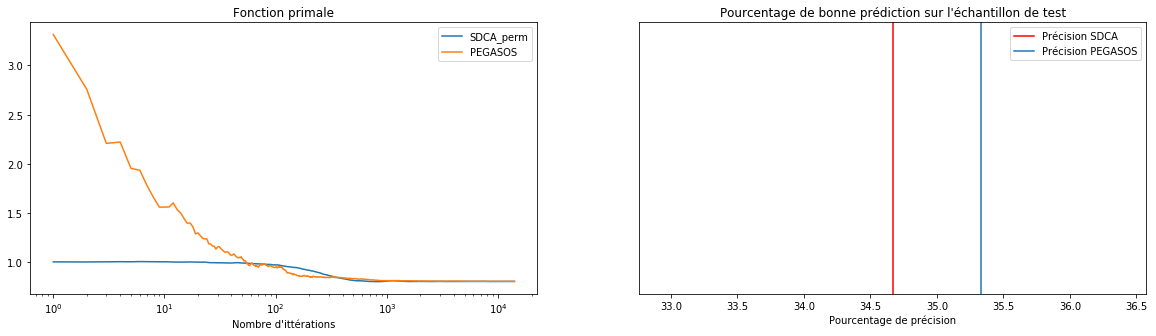

In [14]:
w2_SDCA = SDCA_perm(20,2000,Xtrain2,ytrain2,1,method="random")[0]
primal_list2_SDCA=SDCA_perm(20,2000,Xtrain2,ytrain2,1,method="random")[1]
y_result2_SDCA = np.sign(Xtest2.dot(w2_SDCA))


w2_pegasos = pegasos(20,Xtrain2,ytrain2,1)[0]
primal_list2_pegasos=pegasos(20,Xtrain2,ytrain2,1)[1]
y_result2_pegasos = np.sign(Xtest2.dot(w2_pegasos))

fig = plt.figure(figsize=(20,5))


ax1=plt.subplot(121)
plot(primal_list2_SDCA,label="SDCA_perm")
plot(primal_list2_pegasos,label="PEGASOS")
plt.title("Fonction primale")
ax1.set_xscale("log")
plt.legend()
plt.xlabel("Nombre d'ittérations")
plt.subplot(122)
plt.axvline(accuracy(w2_SDCA,X=Xtest2,y=ytest2),label="Précision SDCA",color="red")
plt.axvline(accuracy(w2_pegasos,X=Xtest2,y=ytest2),label="Précision PEGASOS")
plt.title("Pourcentage de bonne prédiction sur l'échantillon de test")
plt.xlabel("Pourcentage de précision")
plt.yticks([])
plt.legend()

plt.show()

Sur ce dataset, les deux convergences sont très comparables en terme de vitesse et de stabilité. En revanche sur la précision, l'algorithme SDCA semble faire légèrement mieux que son concurrent PEGASOS. Dans les deux cas, puisque nous sommes dans un contexte de classification binaire les résultats ici sont plutôt faibles.

Nous allons à présent observer l'influence de la méthode choisie (random ou average) pour le SDCA sur la précision finale obtenue pour chaque dataset :

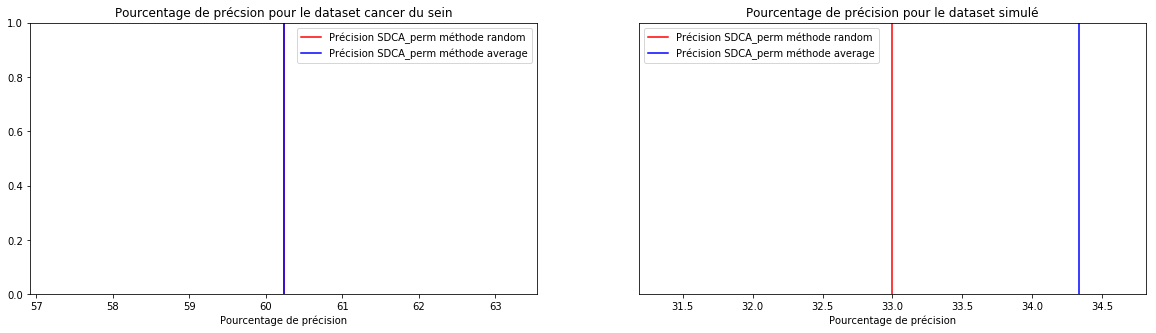

In [15]:
wSDCArandom1 = SDCA_perm(20,2000,Xtrain1,ytrain1,1,method="random")[0]
wSDCAaverage1= SDCA_perm(20,2000,Xtrain1,ytrain1,1,method="average")[0]
wSDCArandom2 = SDCA_perm(20,2000,Xtrain2,ytrain2,1,method="random")[0]
wSDCAaverage2= SDCA_perm(20,2000,Xtrain2,ytrain2,1,method="average")[0]


fig = plt.figure(figsize=(20,5))

plt.subplot(121)
plt.axvline(accuracy(wSDCArandom1,X=Xtest1,y=ytest1),label="Précision SDCA_perm méthode random ",color="red")
plt.axvline(accuracy(wSDCAaverage1,X=Xtest1,y=ytest1),label="Précision SDCA_perm méthode average",color="blue")
plt.title("Pourcentage de précsion pour le dataset cancer du sein")
plt.legend()
plt.xlabel("Pourcentage de précision")
plt.subplot(122)
plt.axvline(accuracy(wSDCArandom2,X=Xtest2,y=ytest2),label="Précision SDCA_perm méthode random",color="red")
plt.axvline(accuracy(wSDCAaverage2,X=Xtest2,y=ytest2),label="Précision SDCA_perm méthode average",color="blue")
plt.title("Pourcentage de précision pour le dataset simulé")
plt.xlabel("Pourcentage de précision")
plt.yticks([])
plt.legend()

plt.show()

Nous constatons que pour le premier dataset les deux méthodes offrent une précision équivalente. Pour le second dataset un léger écart de précision apparaît. Ceci peut s'expliquer par la dimension plus importante (50 contre 30) du second dataset. La différence d'efficacité des deux méthodes est également liée au paramètre $T_0$. Ce paramètre permet de fixer à partir de quelle ittération nous allons tirer le $\omega final$ aléatoirement ou à partir de quelle ittération allons nous effectuer la moyenne selon la méthode employé. Etant donné que le comportement de l'algorithme est en phase transitoire sur les premières ittérations, la méthode "average" risque d'être moins performante si $T_0$ est trop petit. A titre d'illustration nous traçons ci dessous la même étude avec un $T_0$ dix fois moins important :

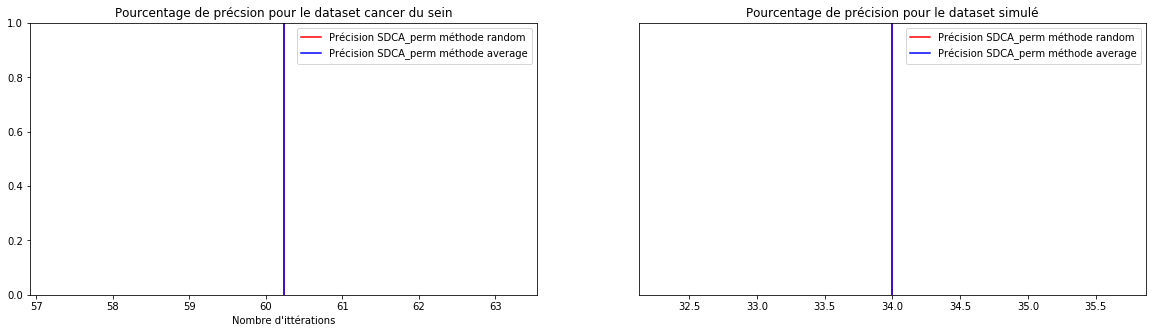

In [16]:
wSDCArandom1 = SDCA_perm(20,100,Xtrain1,ytrain1,1,method="random")[0]
wSDCAaverage1= SDCA_perm(20,100,Xtrain1,ytrain1,1,method="average")[0]
wSDCArandom2 = SDCA_perm(20,100,Xtrain2,ytrain2,1,method="random")[0]
wSDCAaverage2= SDCA_perm(20,100,Xtrain2,ytrain2,1,method="average")[0]


fig = plt.figure(figsize=(20,5))

plt.subplot(121)
plt.axvline(accuracy(wSDCArandom1,X=Xtest1,y=ytest1),label="Précision SDCA_perm méthode random ",color="red")
plt.axvline(accuracy(wSDCAaverage1,X=Xtest1,y=ytest1),label="Précision SDCA_perm méthode average",color="blue")
plt.title("Pourcentage de précsion pour le dataset cancer du sein")
plt.legend()
plt.xlabel("Nombre d'ittérations")
plt.subplot(122)
plt.axvline(accuracy(wSDCArandom2,X=Xtest2,y=ytest2),label="Précision SDCA_perm méthode random",color="red")
plt.axvline(accuracy(wSDCAaverage2,X=Xtest2,y=ytest2),label="Précision SDCA_perm méthode average",color="blue")
plt.title("Pourcentage de précision pour le dataset simulé")
#plt.xlabel("Pourcentage de précision pour le dataset simulé")
plt.yticks([])
plt.legend()

plt.show()

On constate alors que la méthode "average" qui avait de meilleures performances que la méthode "random" sur le second dataset réussi moins bien ici. Ceci s'explique par l'influence du régime transitoire qui, si $T_0$ est trop petit, peut pénaliser cette méthode.

## V) Conclusions

Nous avons dans notre étude implémenté l'algorithme SDCA ainsi qu'une variante avec une stratégie sous Gradient (PEGASOS). Nous avons alors comparer ces algorithmes sous deux variantes, en terme de minimisation du problème primal et de précision de la classification associé sur deux datasets distincts.

Les deux algorithmes ont quasiment les même performances en terme de précision sur nos deux datasets (avec un léger avantage peut être pour le SDCA). Concernant la minimisation de la fonction primale notre étude semble montrer que l'algorithme PEGASOS descend plus vite vers un minimum de la fonction mais mets plus de temps que SDCA à se stabiliser sur les premières itérations.